# DD2437
## Lab 1B - Part I

**Group 26**

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from ipywidgets import interact, IntSlider, fixed, Play, ToggleButtons
from matplotlib.ticker import MaxNLocator

In [41]:
# Set seed
np.random.seed(42)

## HYPERPARAMETER TUNNING

In [42]:
nodes_hidden_layer = 0#4
nodes_output_layer = 1
number_iterations = 1
step_length = 1
number_epochs = 100
learning_rate = 0.05
alpha = 0.9

In [43]:
def transfer_function(x):
  return 2/(1+np.exp(-x))-1

def der_transfer_function(x):
  phi = transfer_function(x)
  return (1+phi)*(1-phi)/2

### 3.1.1 Classification of linearly non-separable data

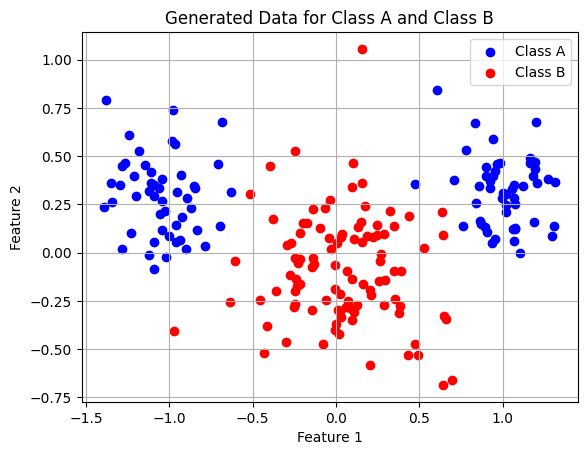

In [44]:
n = 100
mA = np.array([1.0, 0.3])
mB = np.array([0.0, -0.1])
sigmaA = 0.2
sigmaB = 0.3
half_1 = np.random.randn(int(np.round(0.5*n)),1) * sigmaA - mA[0]
half_2 = np.random.randn(int(np.round(0.5*n)),1) * sigmaA + mA[0]
classA_0 = np.vstack((half_1, half_2))
classA_1 = np.random.randn(n,1) * sigmaA + mA[1]
classA = np.hstack((classA_0, classA_1))
classB = np.random.randn(n, 2) * sigmaB + mB

plt.scatter(classA[:, 0], classA[:, 1], color='blue', label='Class A')
plt.scatter(classB[:, 0], classB[:, 1], color='red', label='Class B')
plt.title('Generated Data for Class A and Class B')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()

In [45]:
def forward_pass(w, v, X):
  '''Hidden layer'''
  ones = np.ones(X.shape[1]).reshape((1, X.shape[1]))
  # print(X.shape,ones.shape)
  X_in = np.vstack((X, ones))
  # print(X_in, X_in.shape)
  h_in = np.dot(w,X_in) # (hidden,2n)
  # print(h_in, h_in.shape)
  h_out = transfer_function(h_in) #(hidden, 2n)
  # print(h_out, h_out.shape)
  '''Output layer'''
  H = np.vstack((h_out, ones))
  # print(H, H.shape)
  o_in = np.dot(v,H)
  # print(o_in, o_in.shape)
  o_out = transfer_function(o_in)
  # print(o_out, o_out.shape)
  return h_in, h_out, o_in, o_out, X_in, H

def backward_pass(h_in, h_out, o_in, o_out, t, v):
  phi_dot_o = der_transfer_function(o_in)
  delta_o = np.multiply((o_out - t), phi_dot_o)
  # print(delta_o, delta_o.shape)
  phi_dot_h = der_transfer_function(h_in)
  delta_h = np.multiply((np.dot(np.transpose(v[:,:-1]),delta_o)),phi_dot_h) # WE DON'T USE THE BIAS COLUMN FROM THE V MATRIX!!!
  # print(delta_h, delta_h.shape)
  return delta_o, delta_h

def backprop(classA_train, classB_train, hidden_dim, classA_val=None, classB_val=None, batch_size=None):

  X_train = np.vstack((classA_train, classB_train))
  t_train = np.hstack((-np.ones(classA_train.shape[0]), np.ones(classB_train.shape[0])))
  perm = np.random.permutation(X_train.shape[0])
  X_train, t_train = X_train[perm], t_train[perm]
  X_train = np.transpose(X_train) # (2,2n)
  t_train = np.transpose(t_train) # (1,2n)

  '''
  If validation data is provided, use it. Otherwise,
  we reuse training data for validation.
  '''
  if classA_val is not None and classB_val is not None:
    X_val = np.vstack((classA_val, classB_val))
    t_val = np.hstack((-np.ones(classA_val.shape[0]), np.ones(classB_val.shape[0])))
    perm = np.random.permutation(X_val.shape[0])
    X_val, t_val = X_val[perm], t_val[perm]
    X_val = np.transpose(X_val) # (2,2n)
    t_val = np.transpose(t_val) # (1,2n)
  else:
    X_val = X_train
    t_val = t_train

  w_history = []
  v_history = []
  classification_accuracy_history = []
  mse_history_train = []
  mse_history_val = []
  w = np.random.random((hidden_dim,3)).reshape(hidden_dim,3) #(hidden, 2+bias)
  v = np.random.random((nodes_output_layer, hidden_dim+1)).reshape(nodes_output_layer,hidden_dim+1) #(output, hidden+bias)
  # print(f'W: {w}, {w.shape}')
  # print(f'V: {v}, {v.shape}')
  delta_w = 0
  delta_v = 0
  # For each epoch
  for _ in range(number_epochs):
    # For each batch (unless batch_size is None, then we use the whole set)
    for i in range(0, X_train.shape[1], batch_size if batch_size is not None else X_train.shape[1]):
      if batch_size is not None:
        X_batch = X_train[:, i:i+batch_size]
        t_batch = t_train[i:i+batch_size]
      else:
        X_batch = X_train
        t_batch = t_train
      '''1st: FORWARD PASS: Activities of the nodes are computed layer for layer'''
      h_in, h_out, o_in, o_out, X_bias, H_bias = forward_pass(w, v, X_batch)
      ''' 2nd: BACKWARD PASS: Error signal (delta) computed for each node'''
      delta_o, delta_h = backward_pass(h_in, h_out, o_in, o_out, t_batch, v)
      ''' 3rd: WEIGHT UPDATE'''
      delta_w = delta_w*alpha - (1-alpha)*np.dot(delta_h, np.transpose(X_bias))
      delta_v = delta_v*alpha - (1-alpha)*np.dot(delta_o, np.transpose(H_bias))
      # print(delta_v)
      w += learning_rate*delta_w
      v += learning_rate*delta_v
      # print(v)
    # We only check accuracy and MSE after each epoch, not for each batch
    classification_accuracy_history.append(check_accuracy(w,v,X_val,t_val))
    mse_history_train.append(mse(w,v,X_train,t_train))
    mse_history_val.append(mse(w,v,X_val,t_val))
    w_history.append(w.copy())
    v_history.append(v.copy())
    #print(f'Epoch {_+1}/{number_epochs} - Accuracy: {accuracy*100:.2f}%')
  hidden_node_accuracy = check_accuracy(w,v,X_val,t_val)
  # print(v_history)
  return np.array(w_history), np.array(v_history), np.array(classification_accuracy_history), np.array(mse_history_train), np.array(mse_history_val), hidden_node_accuracy


def check_accuracy(w,v,X,t):
  _, _, Z_data, _, _, _ = forward_pass(w, v, X)
  labels_pred = np.sign(Z_data).flatten()
  correct = 0
  for i in range(labels_pred.shape[0]):
      if labels_pred[i] == t[i]:
          correct += 1
  return correct / X.shape[1]

'''
Mean Squared Error accuracy function
Follows the formula: MSE = 1/N * sum((t - Z_data)^2) / 4
Note that we're dividing by 4 to account for worst case
scenario where t = 1 and Z_data = -1.
'''
def mse(w, v, X, t):
  _, _, Z_data, _, _, _ = forward_pass(w, v, X)
  labels_pred = np.sign(Z_data).flatten()
  return np.mean((t - labels_pred)**2) / 4

#### Hidden nodes effect

In [46]:
def plot_decision_boundary(epoch_idx, title, w_history, v_history, classA, classB, hidden_dim):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot data points
    ax.scatter(classA[:, 0], classA[:, 1], color='blue', label='Class A')
    ax.scatter(classB[:, 0], classB[:, 1], color='red', label='Class B')

    # Then we create the decision boundary line
    x_boundry = np.linspace(-3, 3, 100)
    w = np.array(w_history[epoch_idx]).reshape(hidden_dim,3)
    v = np.array(v_history[epoch_idx]).reshape(nodes_output_layer, hidden_dim+1)
    # print(w, w.shape)
    # print(v,v.shape)

    xx, yy = np.meshgrid(
    np.linspace(-2, 2, 400),
    np.linspace(-2, 2, 400)
          )
    X_grid = np.vstack([xx.ravel(), yy.ravel()])

    _, _, o_in, _, _, _ = forward_pass(w, v, X_grid)

    Z = o_in
    Z_plot = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z_plot, levels=50, cmap='coolwarm', alpha=0.4)
    plt.contour(xx, yy, Z_plot, levels=[0], colors='black', linewidths=2)

    '''OBSERVING BOUNDARIES FROM INPUT TO HIDDEN LAYER'''
    # for i in range(hidden_dim):
    #   y_boundry = - (w[i,0]/w[i,1]) * x_boundry - (w[i,2]/w[i,1])
    #   ax.plot(x_boundry, y_boundry, label=f"Decision boundary {i}")

    '''OBSERVING BOUNDARIES FROM INPUT TO OUTPUT LAYER'''
    # for i in range(nodes_output_layer):
    #   v_a = v[:,:-1]
    #   print(f"v_a: {v_a}, {v_a.shape}")
    #   const_1 = (np.dot(v_a[i,:],w[:,0])).T #Not necessary T
    #   const_2 = (np.dot(w[:,2].T,v_a[i,:]) + v[i,-1])
    #   const_den = (np.dot(v_a[i,:],w[:,1])).T #Not necessary T
    #   # print(const_2)
    #   y_boundry = - x_boundry *  const_1/const_den- const_2/const_den
    #   ax.plot(x_boundry, y_boundry, label=f"Decision boundary {i}")

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.legend()
    ax.set_title(title)


def plot_accuracy(mse_history, classification_accuracy_history, title, title_suffix=''):
    plt.figure(figsize=(8, 5))
    plt.plot(classification_accuracy_history, label='Classification Accuracy')
    plt.plot(mse_history, label='MSE')
    plt.title(title + " " + title_suffix)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.show()
    print(f"Final classification accuracy: {classification_accuracy_history[-1]*100:.2f}%")
    print(f"Final MSE: {mse_history[-1]:.4f}")

def plot_node_accuracy(node_accuracy_history, title, title_suffix=''):
    plt.figure(figsize=(8, 5))
    plt.plot(node_accuracy_history, label='Accuracy')
    plt.title(title + " " + title_suffix)
    plt.xlabel('Number of hidden layer nodes')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.show()

In [47]:
def train_and_evaluate(classA_train, classB_train, classA_val=None, classB_val=None, title_suffix='', batch_size=None, desired_nodes_hidden_layers = [1]):
  hidden_node_accuracy_history = [[] for _ in range(100)]
  hidden_node_mse_train_history = [[] for _ in range(100)]
  hidden_node_mse_val_history = [[] for _ in range(100)]
  for i in desired_nodes_hidden_layers:
    hidden_node_history = [[] for _ in range(100)]
    for run in range(100):
      w_history, v_history, classification_accuracy_history, mse_history_train, mse_history_val, hidden_node_accuracy= backprop(classA_train, classB_train, i, classA_val, classB_val, batch_size=batch_size)
      hidden_node_history[run].append([w_history, v_history, classification_accuracy_history, mse_history_train, mse_history_val, hidden_node_accuracy])
      hidden_node_accuracy_history[run].append(hidden_node_accuracy)
      hidden_node_mse_train_history[run].append(mse_history_train[-1])
      hidden_node_mse_val_history[run].append(mse_history_val[-1])
    # print(np.array(hidden_node_accuracy_history).shape)
    # Get best performing run for this hidden layer node count
    best_run_idx = np.argmax([hidden_node_accuracy_history[run][-1] for run in range(100)])
    w_history, v_history, classification_accuracy_history, mse_history_train, mse_history_val, hidden_node_accuracy = hidden_node_history[best_run_idx][0]
    title = f'Backprop with two-layer perceptron network (Hidden layer: {i})'
    if classA_val is None and classB_val is None: #In order to plot something
      classA_plot = classA_train
      classB_plot = classB_train
    else:
      classA_plot = classA_val
      classB_plot = classB_val
    plot_decision_boundary(epoch_idx=number_epochs-1,
                          title=f"{title} - (Best run out of 100)",
                          w_history=w_history,
                          v_history=v_history,
                          classA=classA_plot,
                          classB=classB_plot,
                          hidden_dim=i)
    plot_accuracy(mse_history_val, classification_accuracy_history, title, f"{title_suffix} (Best run out of 100)")
  # Get the best perfor
  # Get mean of hidden node accuracy across runs for each hidden layer node count
  hidden_node_accuracy_history_mean = np.mean(np.array(hidden_node_accuracy_history), axis=0)
  hidden_node_mse_train_history_mean = np.mean(np.array(hidden_node_mse_train_history), axis=0)
  hidden_node_mse_val_history_mean = np.mean(np.array(hidden_node_mse_val_history), axis=0)
  if len(desired_nodes_hidden_layers) > 1:
    plot_node_accuracy(np.array(hidden_node_accuracy_history_mean), f'Classification accuracy mean (100 runs) of two-layer perceptron network (Epoch:{number_epochs})')
    plot_node_accuracy(np.array(hidden_node_mse_val_history_mean), f'MSE mean (100 runs) of two-layer perceptron network (Epoch:{number_epochs})')
    for i in range(len(desired_nodes_hidden_layers)):
      print(f"Hidden layer node count: {desired_nodes_hidden_layers[i]} - Final classification accuracy mean: {hidden_node_accuracy_history_mean[i]*100:.2f}%, Final MSE (train) mean: {hidden_node_mse_train_history_mean[i]:.4f}, Final MSE (val) mean: {hidden_node_mse_val_history_mean[i]:.4f}")

In [48]:
'''
Split Data takes a list of data points and divides it
into two groups: training data and validation data,
based on a ration 0-1.
'''
def split_data(data, n_train):
    # Shuffle data identically each time
    np.random.seed(42)
    perm = np.random.permutation(data.shape[0])
    data = data[perm]
    # Calculate split
    n = data.shape[0] * n_train // 1
    n = int(n)
    train_data = data[:n]
    val_data = data[n:]
    return train_data, val_data

### All data for training and vadliation

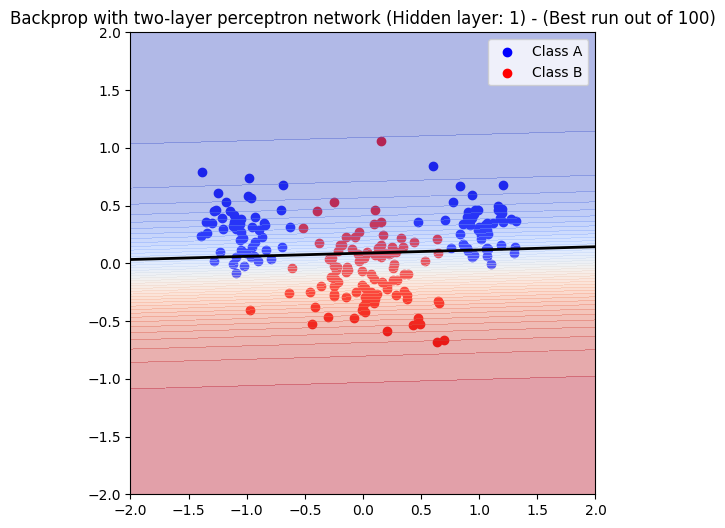

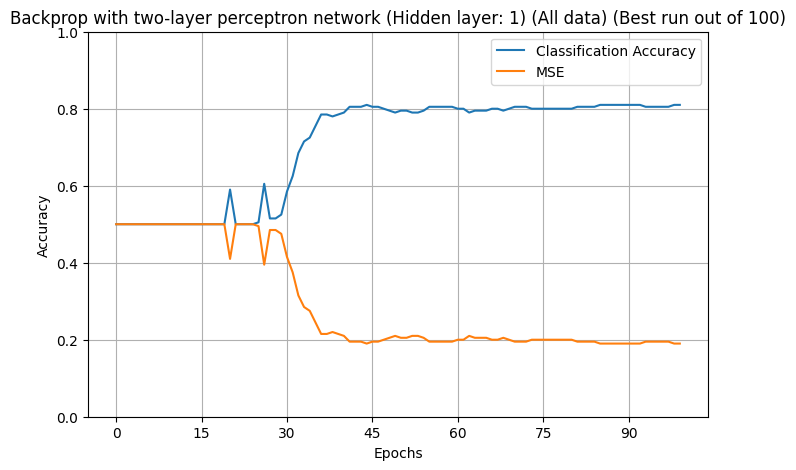

Final classification accuracy: 81.00%
Final MSE: 0.1900


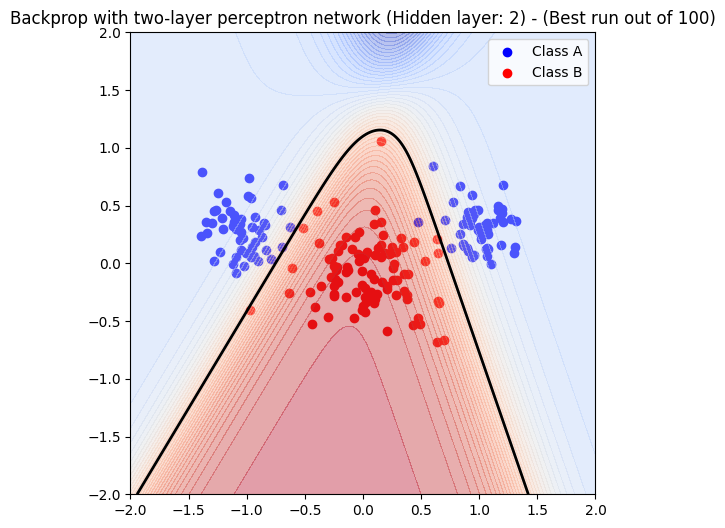

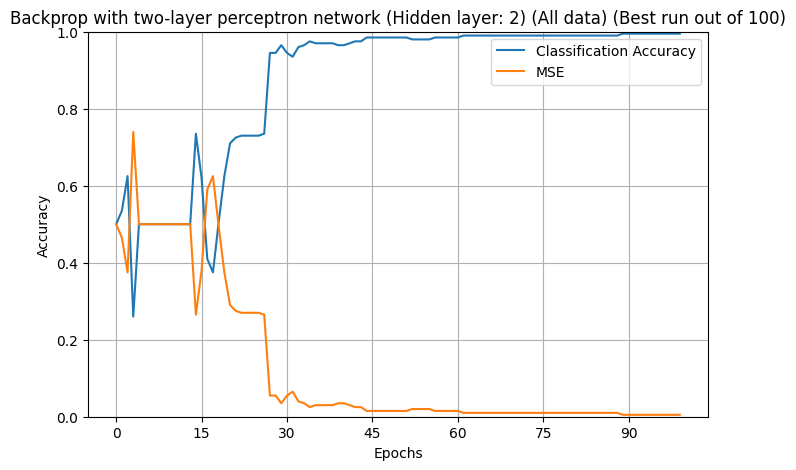

Final classification accuracy: 99.50%
Final MSE: 0.0050


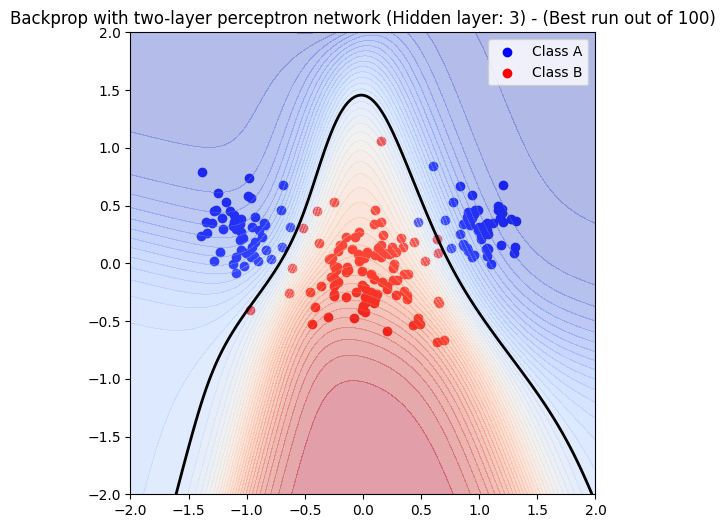

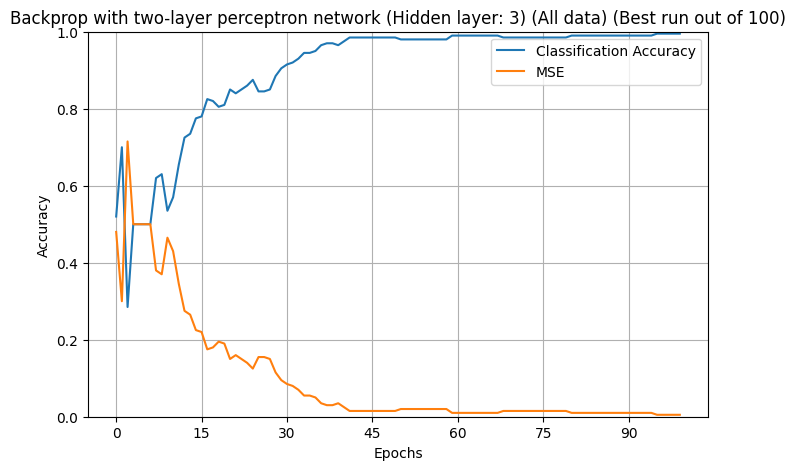

Final classification accuracy: 99.50%
Final MSE: 0.0050


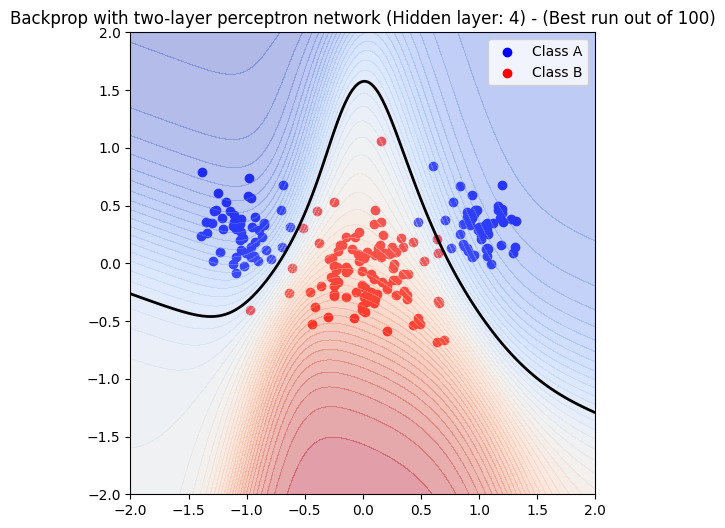

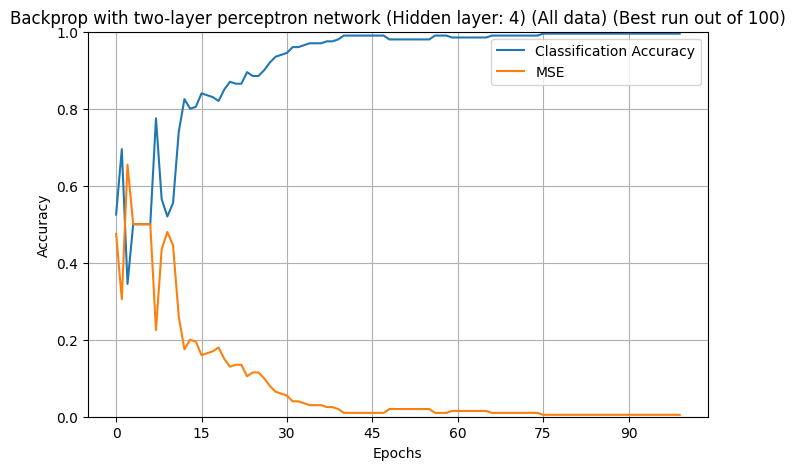

Final classification accuracy: 99.50%
Final MSE: 0.0050


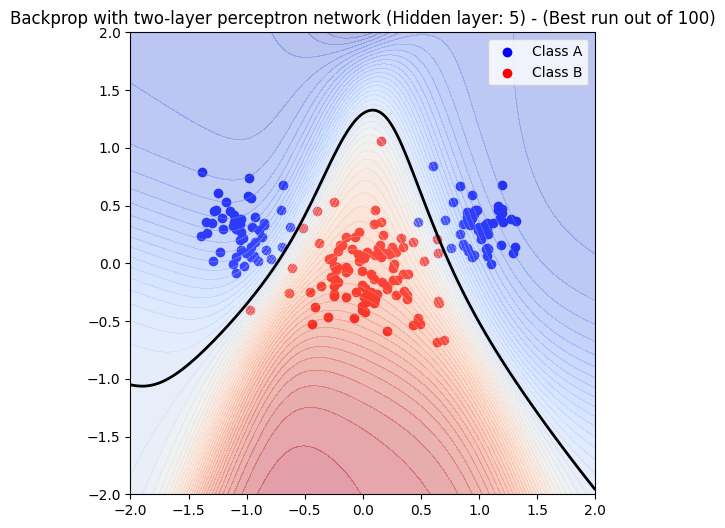

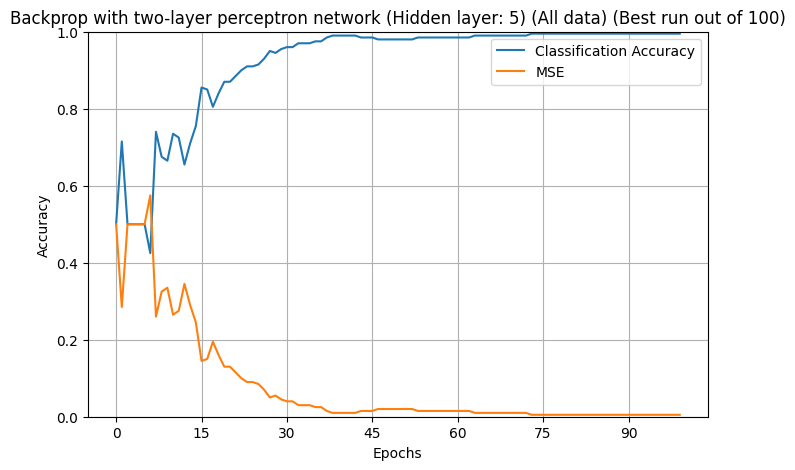

Final classification accuracy: 99.50%
Final MSE: 0.0050


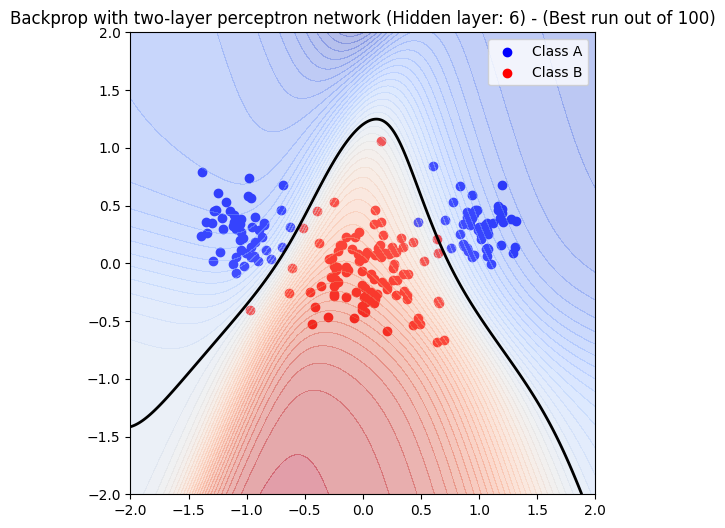

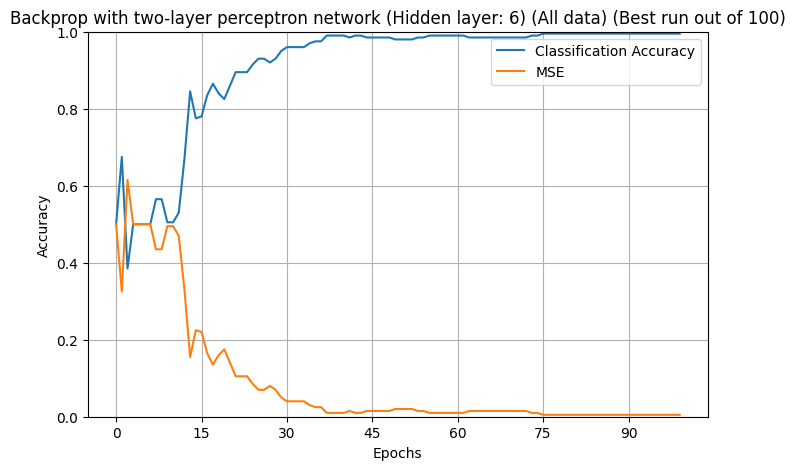

Final classification accuracy: 99.50%
Final MSE: 0.0050


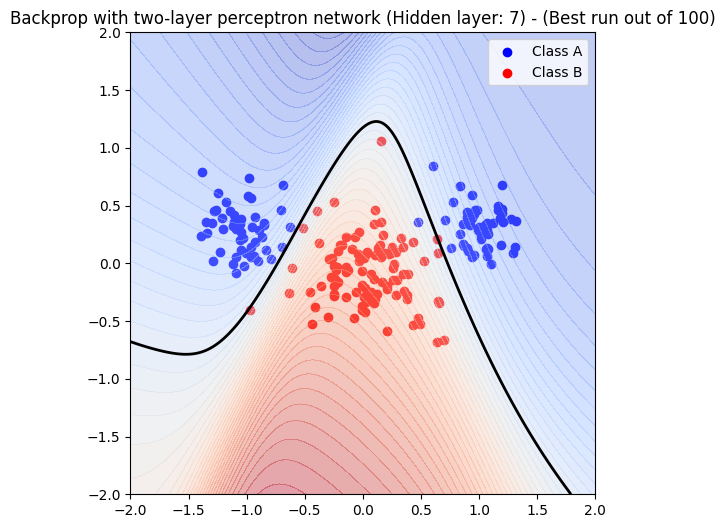

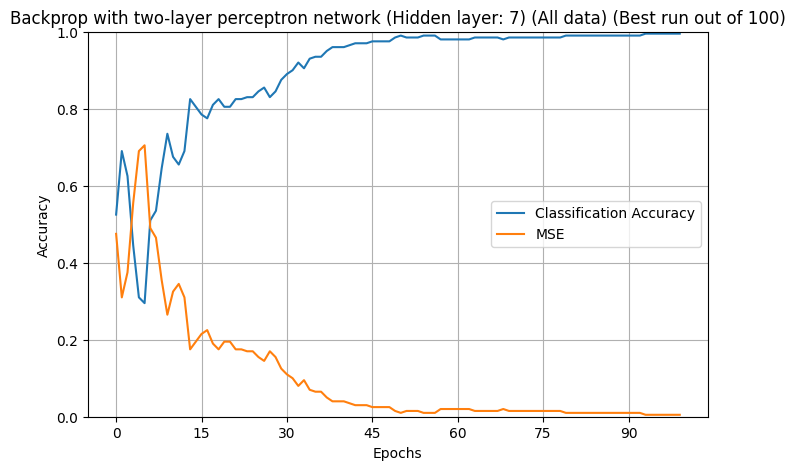

Final classification accuracy: 99.50%
Final MSE: 0.0050


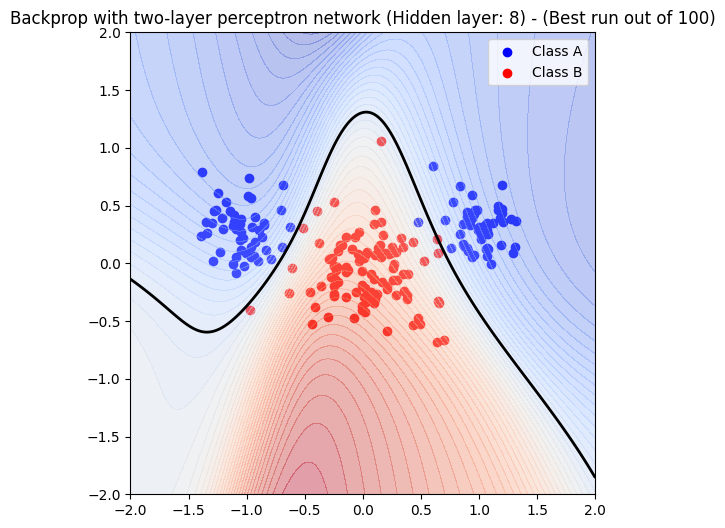

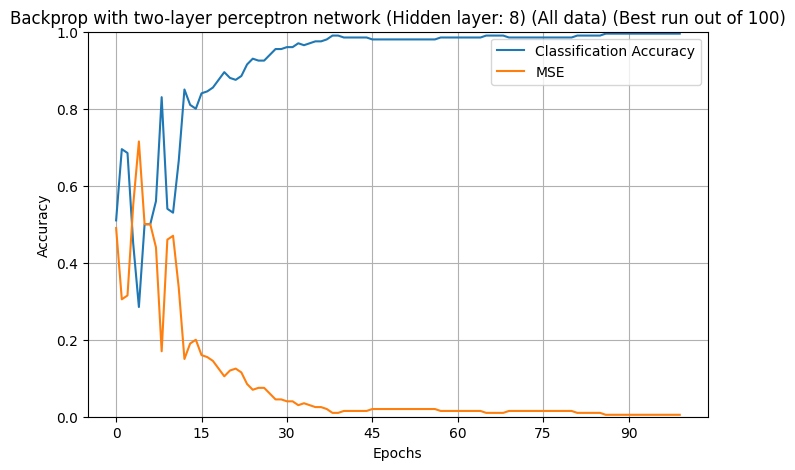

Final classification accuracy: 99.50%
Final MSE: 0.0050


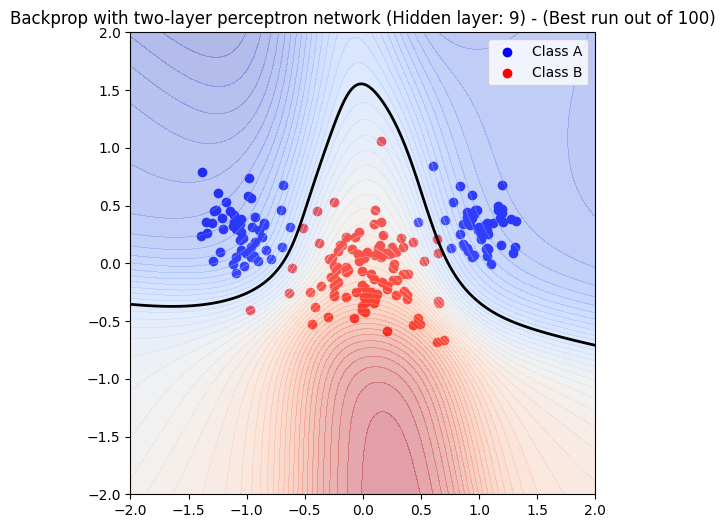

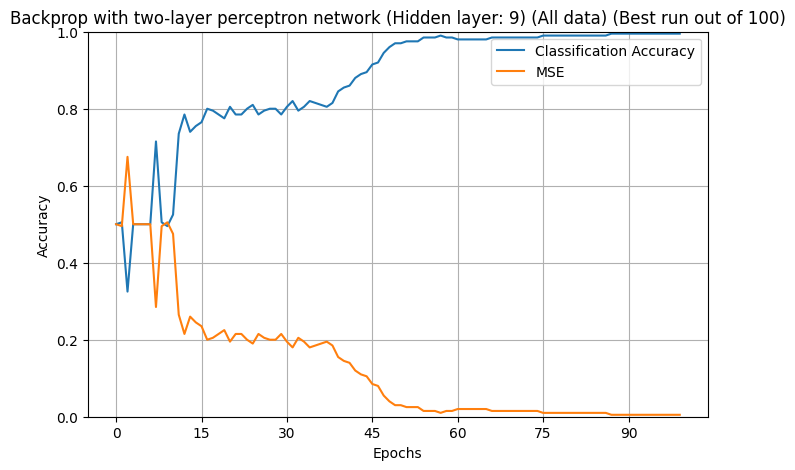

Final classification accuracy: 99.50%
Final MSE: 0.0050


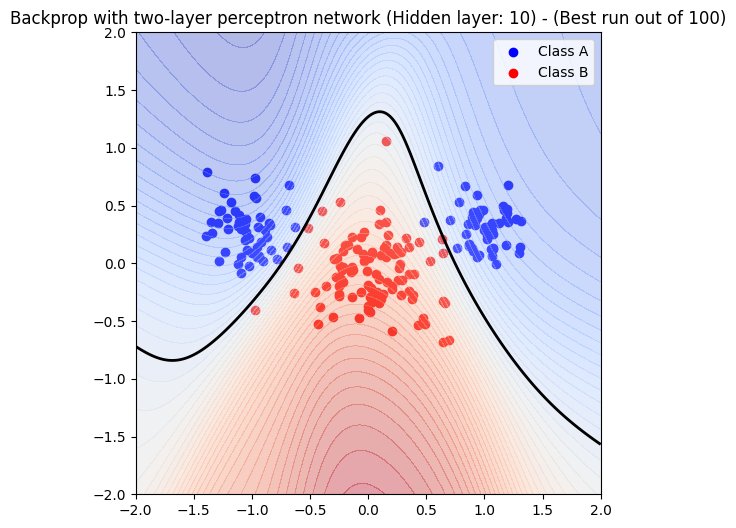

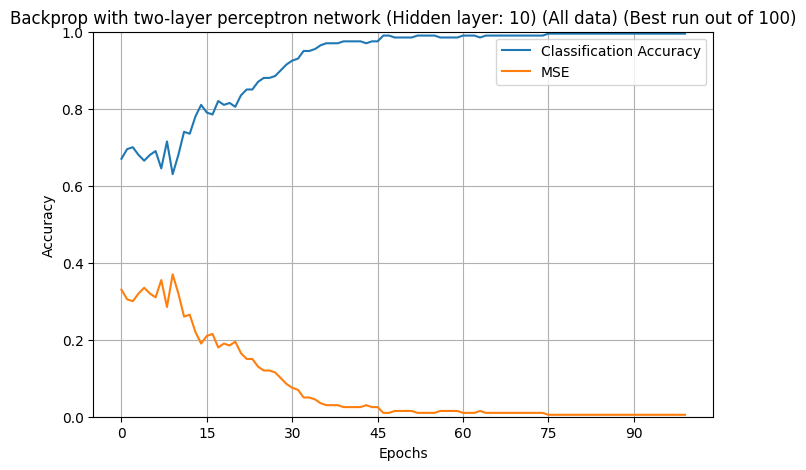

Final classification accuracy: 99.50%
Final MSE: 0.0050


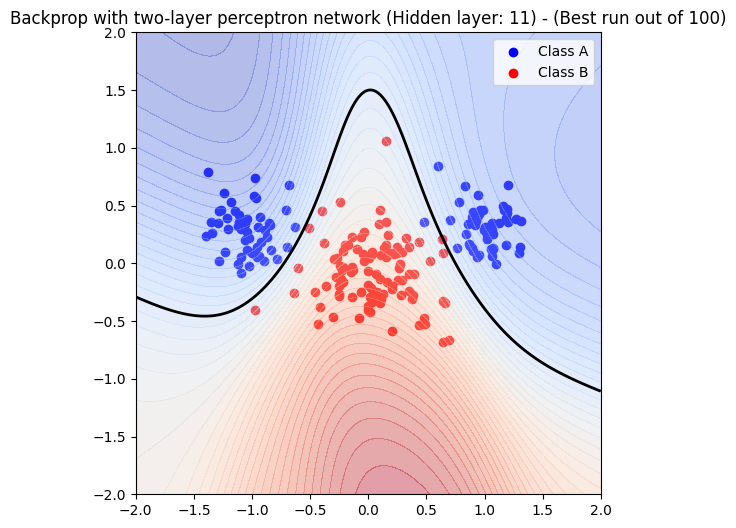

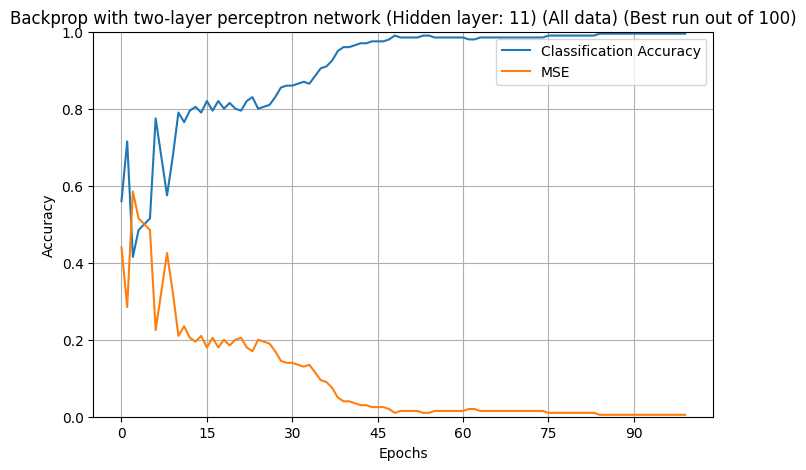

Final classification accuracy: 99.50%
Final MSE: 0.0050


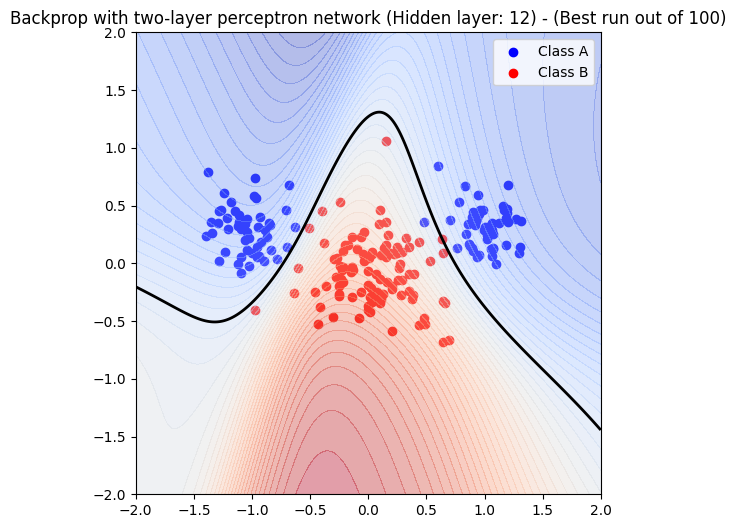

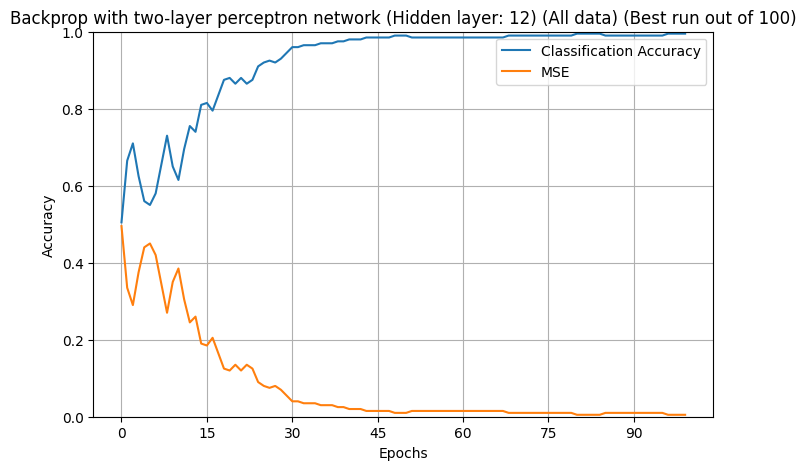

Final classification accuracy: 99.50%
Final MSE: 0.0050


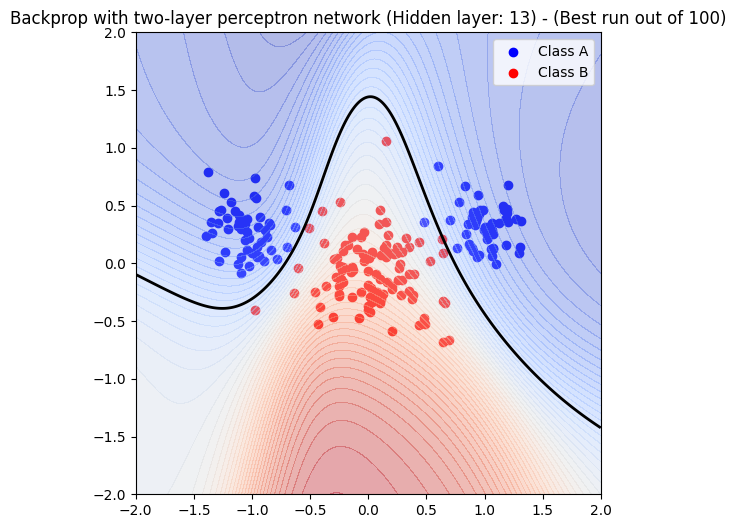

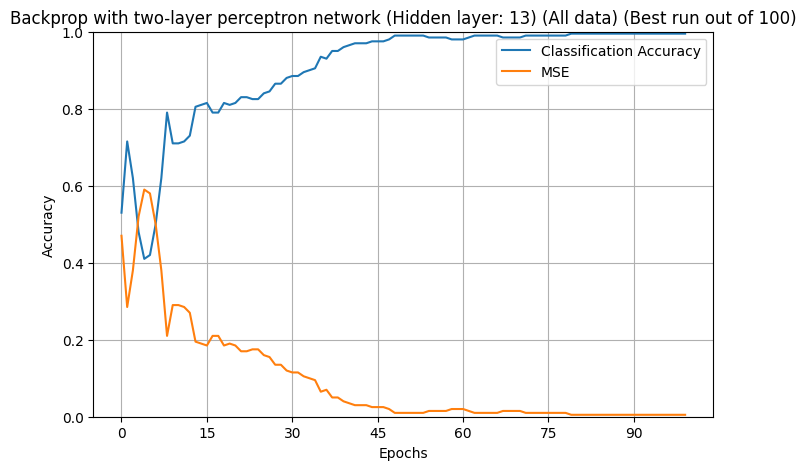

Final classification accuracy: 99.50%
Final MSE: 0.0050


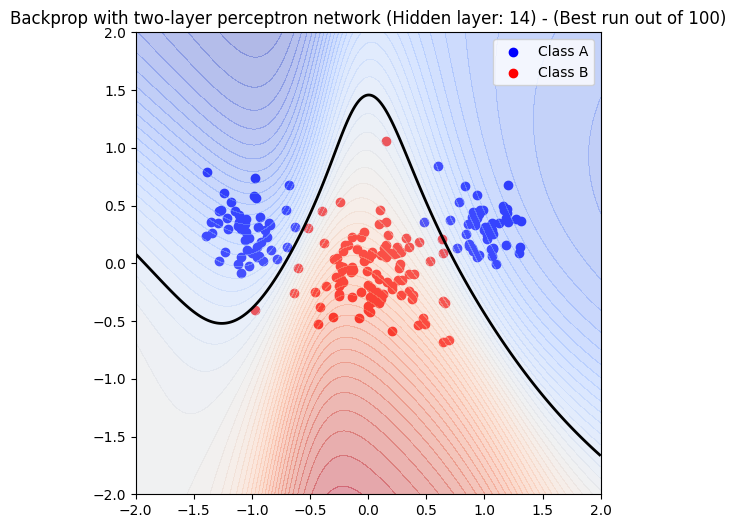

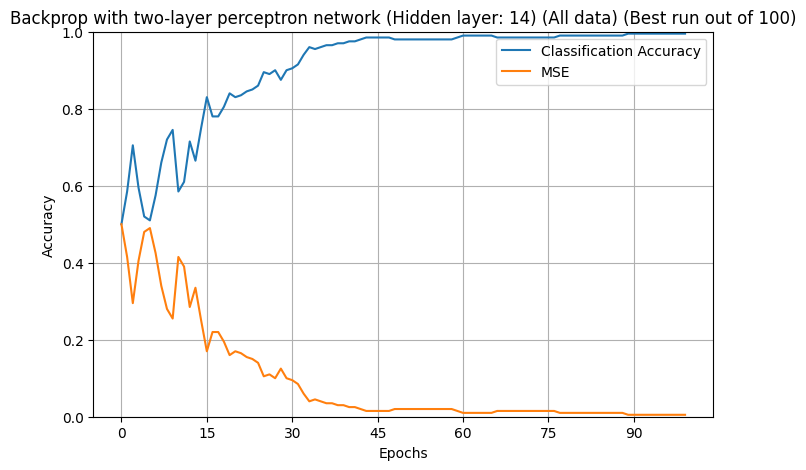

Final classification accuracy: 99.50%
Final MSE: 0.0050


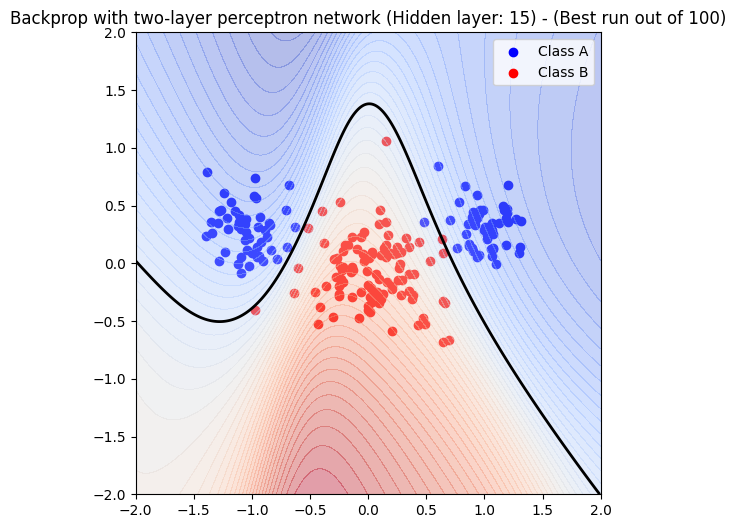

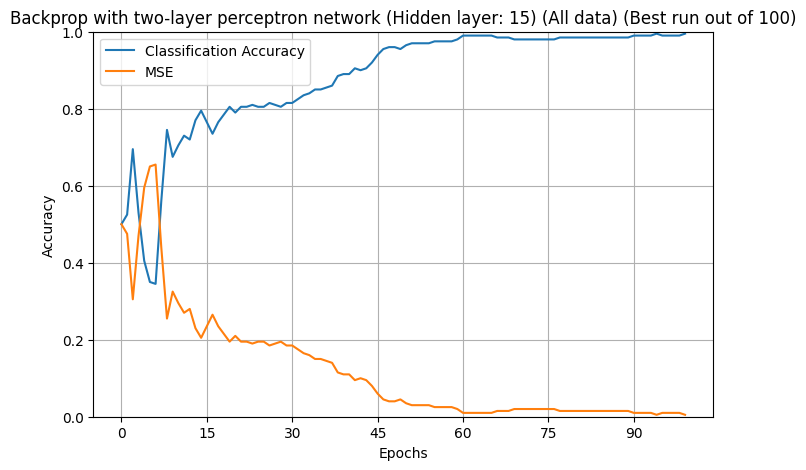

Final classification accuracy: 99.50%
Final MSE: 0.0050


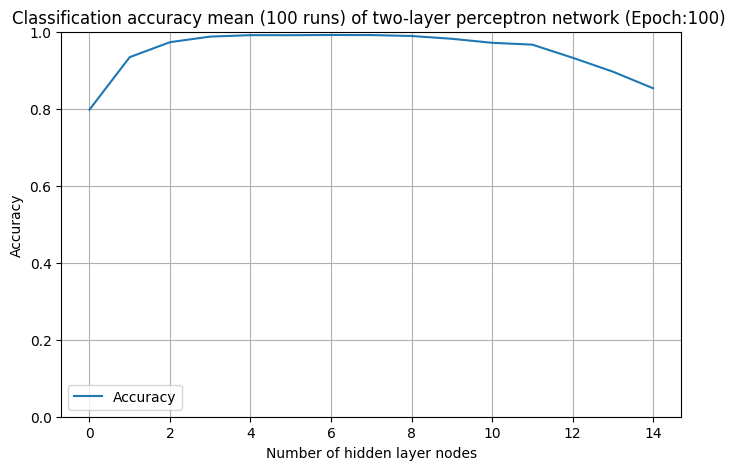

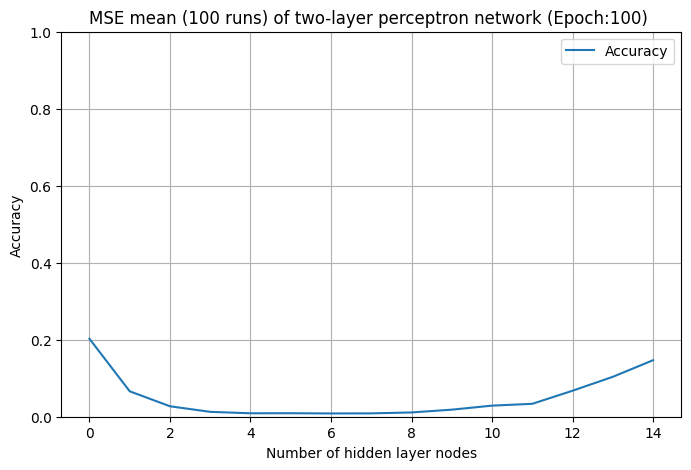

Hidden layer node count: 1 - Final classification accuracy mean: 79.75%, Final MSE (train) mean: 0.2025, Final MSE (val) mean: 0.2025
Hidden layer node count: 2 - Final classification accuracy mean: 93.39%, Final MSE (train) mean: 0.0660, Final MSE (val) mean: 0.0660
Hidden layer node count: 3 - Final classification accuracy mean: 97.28%, Final MSE (train) mean: 0.0271, Final MSE (val) mean: 0.0271
Hidden layer node count: 4 - Final classification accuracy mean: 98.73%, Final MSE (train) mean: 0.0126, Final MSE (val) mean: 0.0126
Hidden layer node count: 5 - Final classification accuracy mean: 99.10%, Final MSE (train) mean: 0.0090, Final MSE (val) mean: 0.0090
Hidden layer node count: 6 - Final classification accuracy mean: 99.09%, Final MSE (train) mean: 0.0091, Final MSE (val) mean: 0.0091
Hidden layer node count: 7 - Final classification accuracy mean: 99.15%, Final MSE (train) mean: 0.0085, Final MSE (val) mean: 0.0085
Hidden layer node count: 8 - Final classification accuracy mea

In [49]:
train_and_evaluate(classA, classB, title_suffix='(All data)', desired_nodes_hidden_layers=range(1,16))

### Random 75/25 split

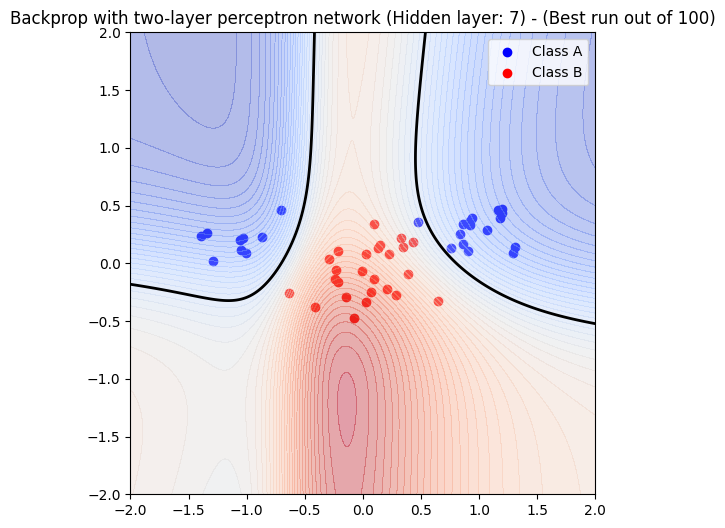

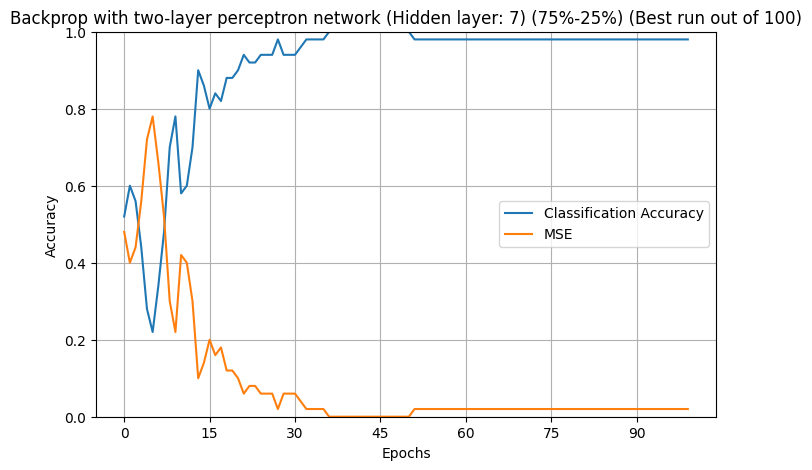

Final classification accuracy: 98.00%
Final MSE: 0.0200


In [50]:
classA_train, classA_val = split_data(classA, 0.75)
classB_train, classB_val = split_data(classB, 0.75)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(75%-25%)', desired_nodes_hidden_layers=[7])

### Random 50/50 split

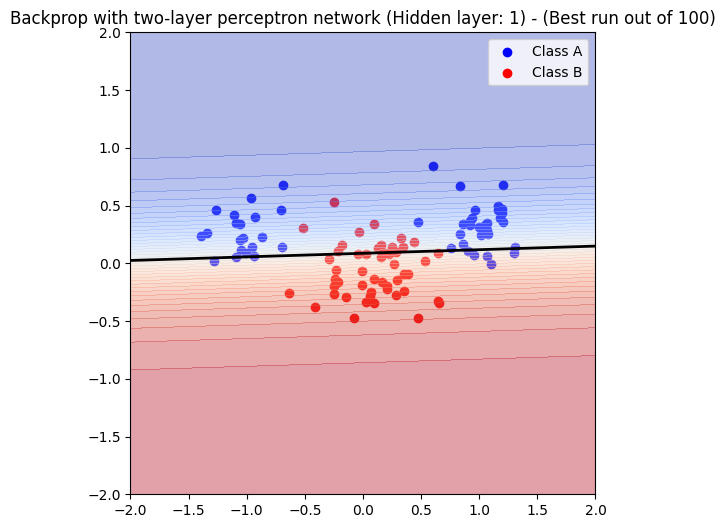

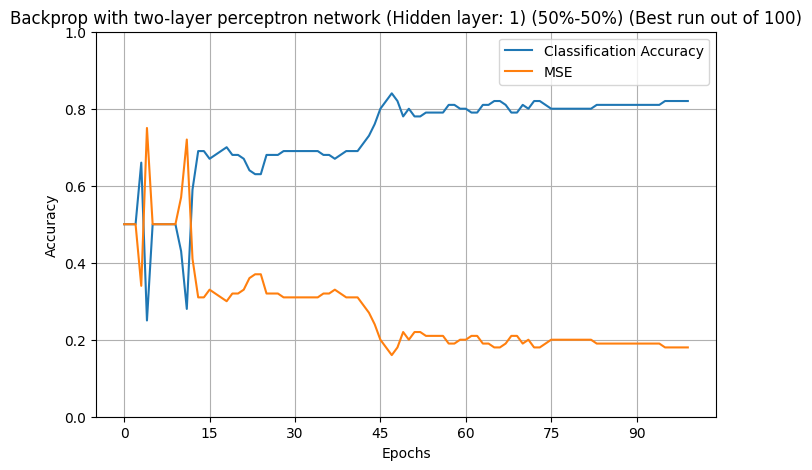

Final classification accuracy: 82.00%
Final MSE: 0.1800


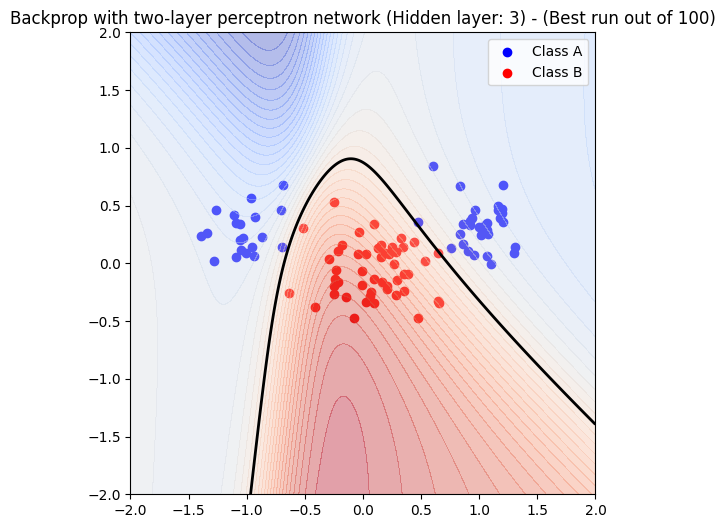

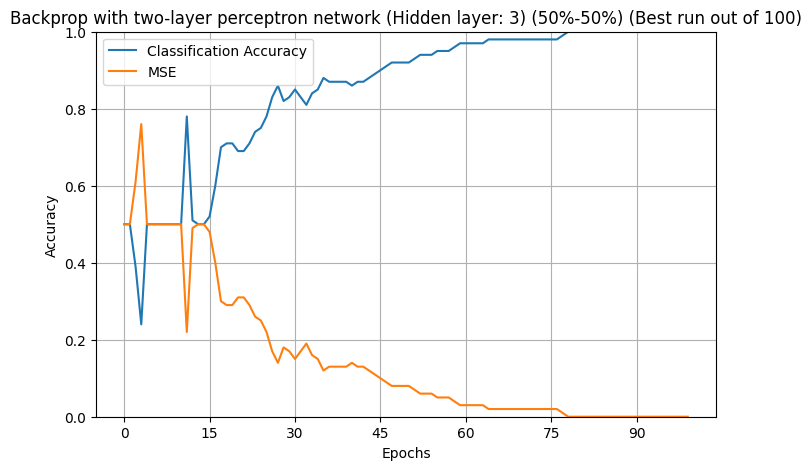

Final classification accuracy: 100.00%
Final MSE: 0.0000


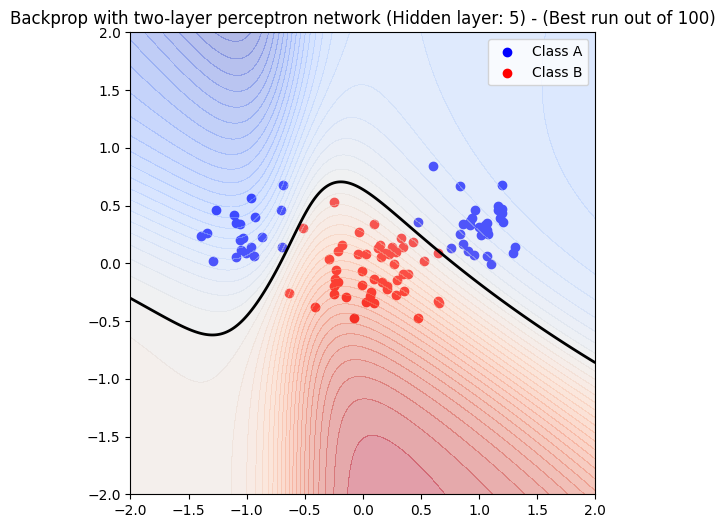

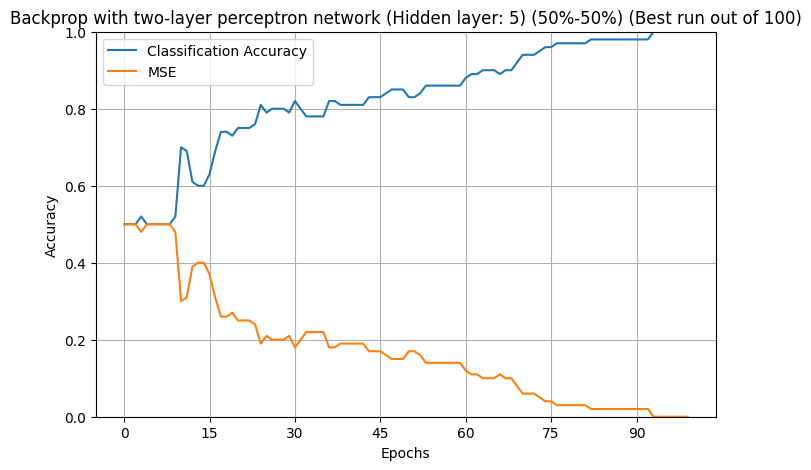

Final classification accuracy: 100.00%
Final MSE: 0.0000


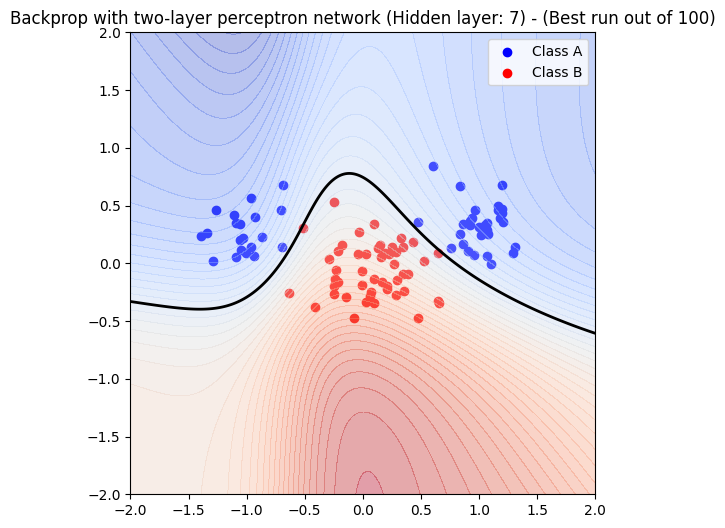

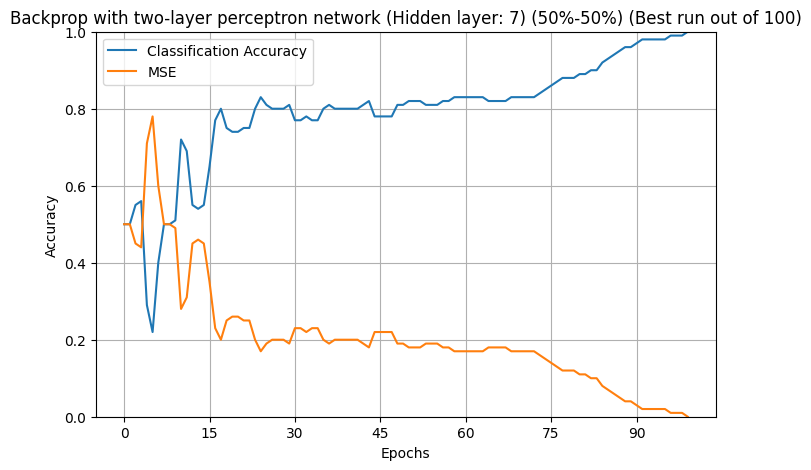

Final classification accuracy: 100.00%
Final MSE: 0.0000


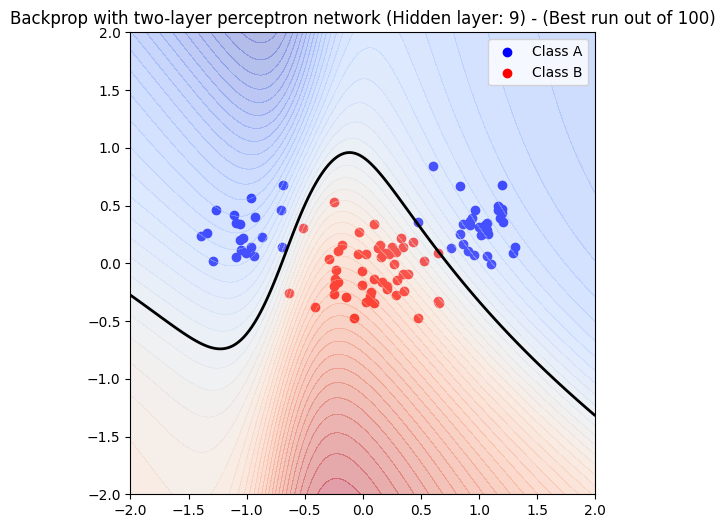

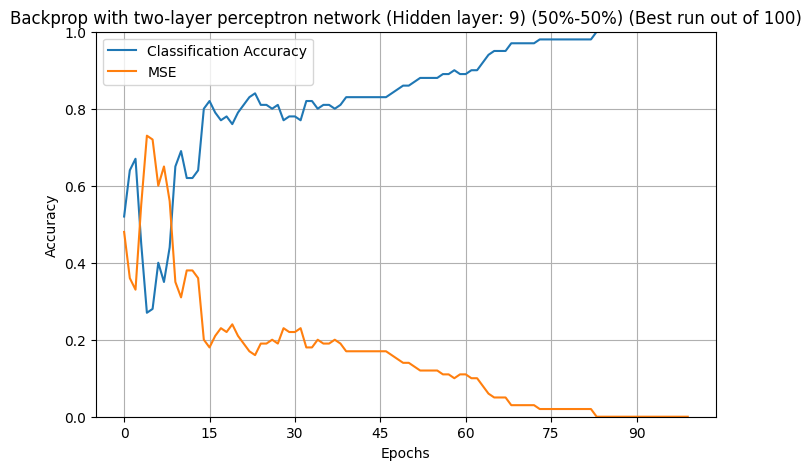

Final classification accuracy: 100.00%
Final MSE: 0.0000


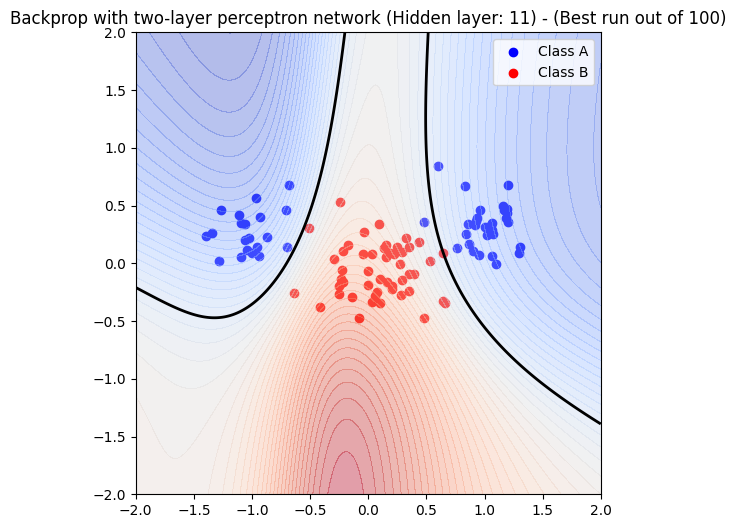

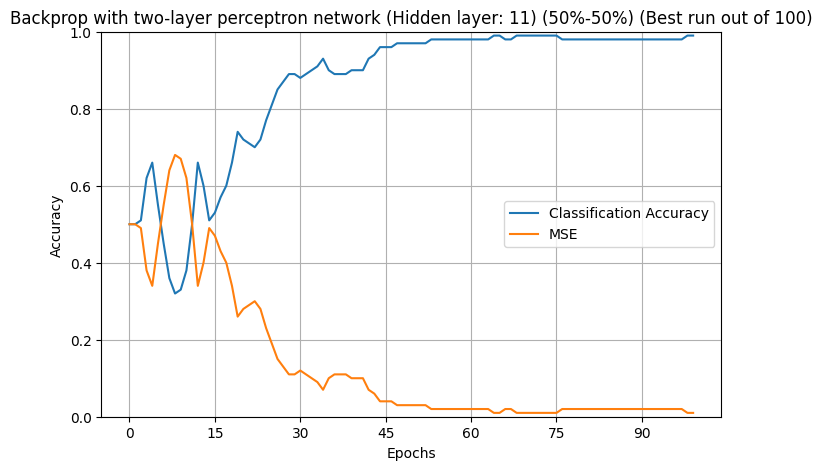

Final classification accuracy: 99.00%
Final MSE: 0.0100


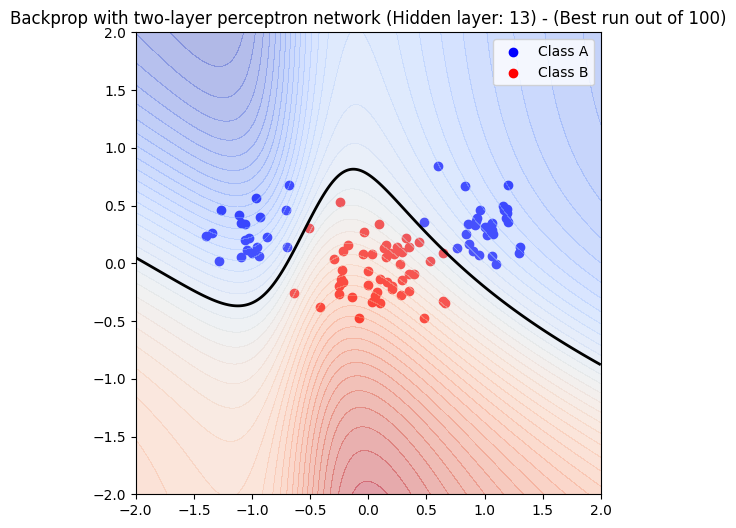

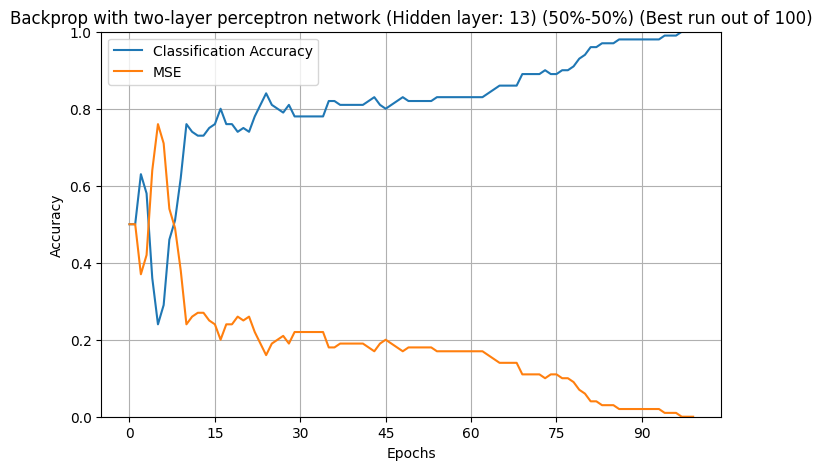

Final classification accuracy: 100.00%
Final MSE: 0.0000


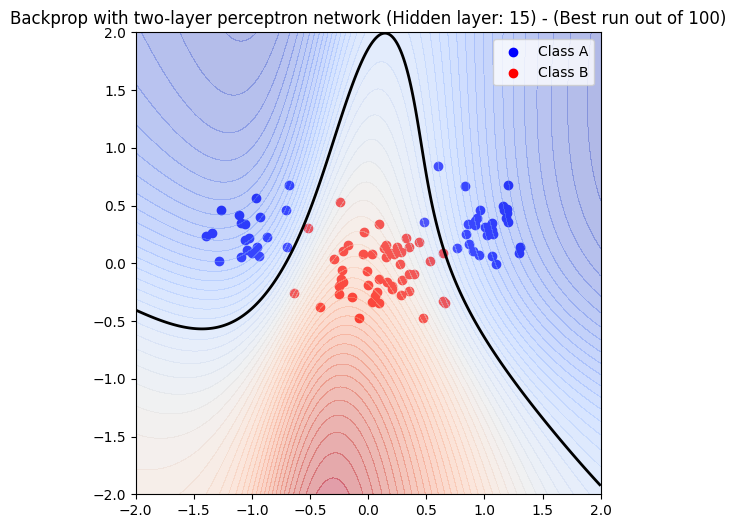

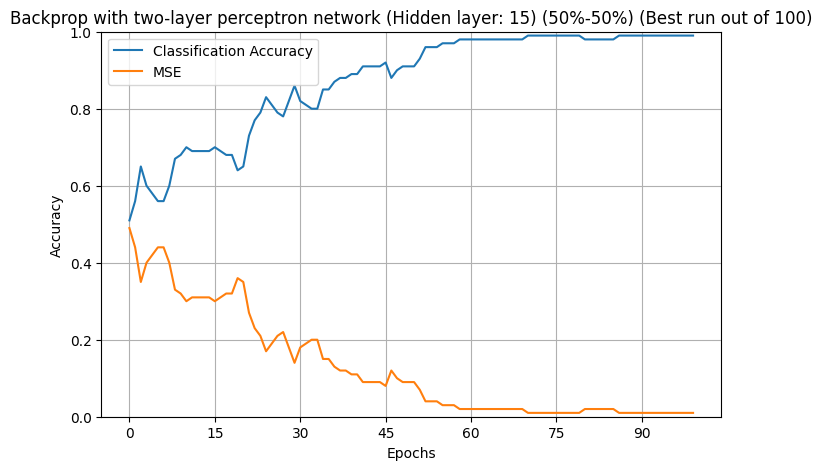

Final classification accuracy: 99.00%
Final MSE: 0.0100


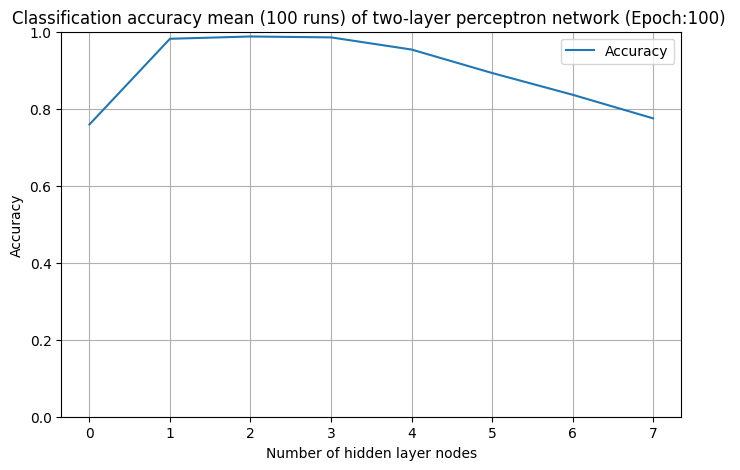

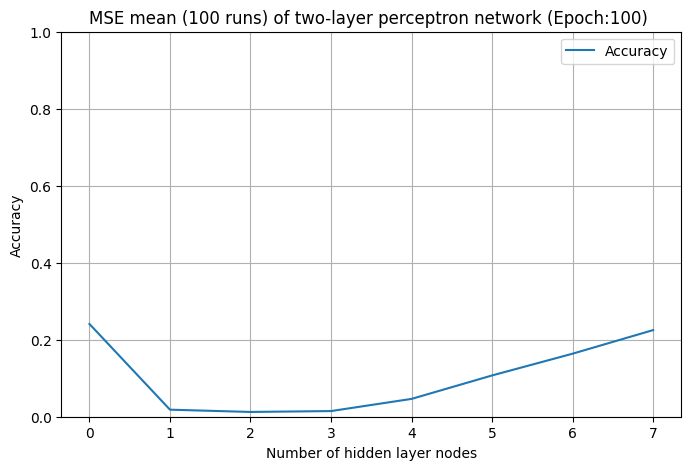

Hidden layer node count: 1 - Final classification accuracy mean: 75.91%, Final MSE (train) mean: 0.1992, Final MSE (val) mean: 0.2409
Hidden layer node count: 3 - Final classification accuracy mean: 98.17%, Final MSE (train) mean: 0.0249, Final MSE (val) mean: 0.0183
Hidden layer node count: 5 - Final classification accuracy mean: 98.76%, Final MSE (train) mean: 0.0124, Final MSE (val) mean: 0.0124
Hidden layer node count: 7 - Final classification accuracy mean: 98.53%, Final MSE (train) mean: 0.0130, Final MSE (val) mean: 0.0147
Hidden layer node count: 9 - Final classification accuracy mean: 95.37%, Final MSE (train) mean: 0.0343, Final MSE (val) mean: 0.0463
Hidden layer node count: 11 - Final classification accuracy mean: 89.28%, Final MSE (train) mean: 0.0737, Final MSE (val) mean: 0.1072
Hidden layer node count: 13 - Final classification accuracy mean: 83.63%, Final MSE (train) mean: 0.1113, Final MSE (val) mean: 0.1637
Hidden layer node count: 15 - Final classification accuracy 

In [51]:
classA_train, classA_val = split_data(classA, 0.50)
classB_train, classB_val = split_data(classB, 0.50)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(50%-50%)', desired_nodes_hidden_layers=[1,3,5,7,9,11,13,15])

### 20% from subset 1 of A and 80% form subset 2 of A

classA_train.shape: (50, 2)
classA_val.shape: (50, 2)


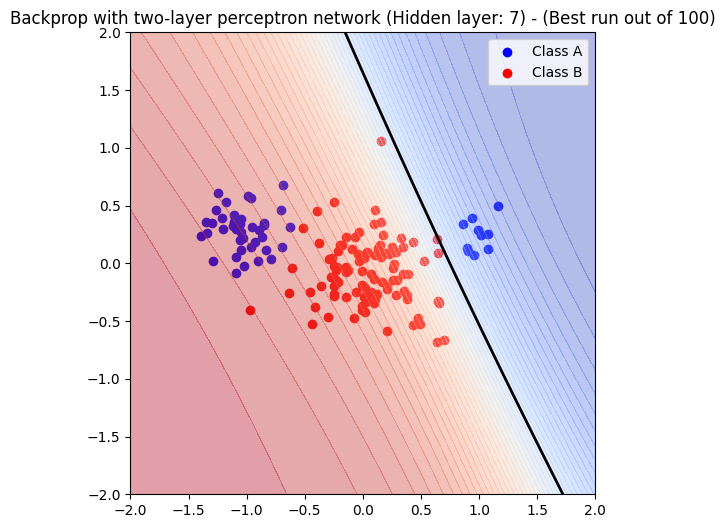

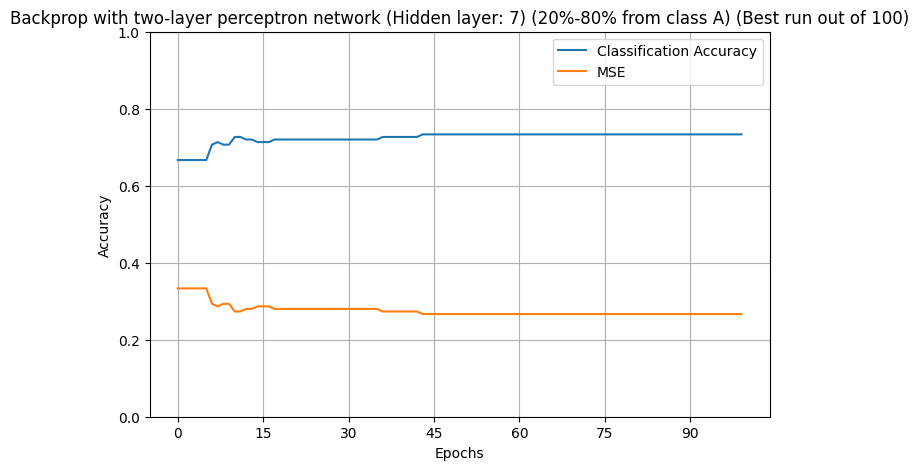

Final classification accuracy: 73.33%
Final MSE: 0.2667


In [52]:
'''
Note that we manually split classA into two parts to regain the
old two groups where first half has mean at -1 and second half at +1.
Then we split those two halves into training and validation sets
with 20%-80% and combine them back together.
'''
classA_one_train, classA_one_val = split_data(classA[:int(np.round(0.5*n))], 0.20)
classA_two_train, classA_two_val = split_data(classA[int(np.round(0.5*n)):], 0.80)
classA_train = np.vstack((classA_one_train, classA_two_train))
classA_val = np.vstack((classA_one_val, classA_two_val))
classB_train = classB
classB_val = classB
print("classA_train.shape:", classA_train.shape)
print("classA_val.shape:", classA_val.shape)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(20%-80% from class A)', desired_nodes_hidden_layers=[7])

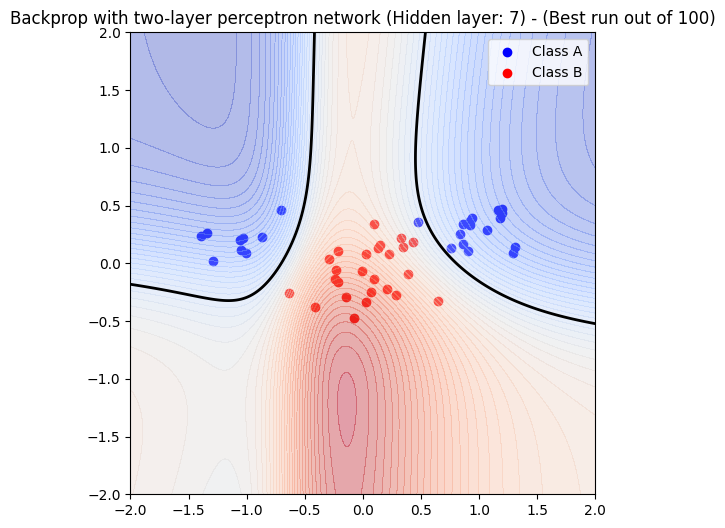

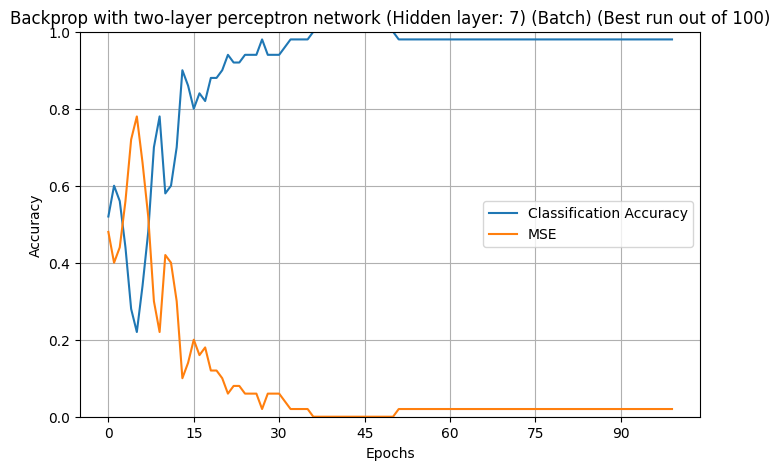

Final classification accuracy: 98.00%
Final MSE: 0.0200


KeyboardInterrupt: 

In [53]:
'''
Exploring the different in terms of validation results comparing
batch vs sequential updates. Where batch is the whole training.
'''
classA_train, classA_val = split_data(classA, 0.75)
classB_train, classB_val = split_data(classB, 0.75)
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(Batch)', batch_size=None, desired_nodes_hidden_layers=[7])
train_and_evaluate(classA_train, classB_train, classA_val, classB_val, title_suffix='(Sequential)', batch_size=1, desired_nodes_hidden_layers=[7])

## 3.1.3

In [ ]:
from matplotlib import cm

def gauss_func(x,y):
  return np.exp(-(x**2+y**2)/10)-0.5


def pattern_target_generator(xx,yy):
  z = gauss_func(xx,yy)
  # print(xx.shape)

  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.plot_surface(xx, yy, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z');

  ndata = len(xx[0])*len(yy[0])
  targets = z.reshape((1,ndata))
  patterns = np.vstack((xx.reshape((1,ndata)), yy.reshape((1,ndata))))
  #print(f"X_train: {patterns.shape}")
  #print(f"Target: {targets.shape}")
  return patterns,targets


def backprop_gauss(x, y, hidden_dim, classA_val=None, classB_val=None, batch_size=None):
  xx,yy = np.meshgrid(x,y)
  X_train, t_train = pattern_target_generator(xx,yy) # (2,len(x)*len(y)), (1,len(x)*len(y))

  perm = np.random.permutation(X_train.shape[1])
  X_train, t_train = X_train[:,perm], t_train[:,perm]

  w_history = []
  v_history = []
  w = np.random.randn(hidden_dim,3).reshape(hidden_dim,3) #(hidden, 2+bias)
  v = np.random.randn(nodes_output_layer, hidden_dim+1).reshape(nodes_output_layer,hidden_dim+1) #(output, hidden+bias)
  # print(f'W: {w}, {w.shape}')
  # print(f'V: {v}, {v.shape}')
  delta_w = 0
  delta_v = 0
  # For each epoch
  for ep in range(number_epochs):
    '''1st: FORWARD PASS: Activities of the nodes are computed layer for layer'''
    h_in, h_out, o_in, o_out, X_bias, H_bias = forward_pass(w, v, X_train)

    original_permutation = np.argsort(perm)
    zz = o_out[:, original_permutation].reshape(len(x), len(y));
    # print(zz.shape)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(f"Epoch: {ep}")

    ''' 2nd: BACKWARD PASS: Error signal (delta) computed for each node'''
    delta_o, delta_h = backward_pass(h_in, h_out, o_in, o_out, t_train, v)
    ''' 3rd: WEIGHT UPDATE'''

    # N = X_train.shape[1]
    # print("max grad_w:", np.max(np.abs(delta_w)))
    # print("max grad_v:", np.max(np.abs(delta_v)))
    # delta_w = -np.dot(delta_h, X_bias.T) / N
    # delta_v = -np.dot(delta_o, H_bias.T) / N

    delta_w = delta_w*alpha - (1-alpha)*np.dot(delta_h, np.transpose(X_bias))
    delta_v = delta_v*alpha - (1-alpha)*np.dot(delta_o, np.transpose(H_bias))

    # print(delta_v)
    w += learning_rate*delta_w
    v += learning_rate*delta_v
    # print(v)
    w_history.append(w.copy())
    v_history.append(v.copy())
    #print(f'Epoch {_+1}/{number_epochs} - Accuracy: {accuracy*100:.2f}%')
  # hidden_node_accuracy = check_accuracy(w,v,X_val,t_val)
  # print(v_history)
  return np.array(w_history), np.array(v_history)


In [ ]:
x = np.linspace(-5,5,21)
y = np.linspace(-5,5,21)
number_epochs = 400
backprop_gauss(x, y, 20)